In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
import xgboost as XGB

In [4]:
sales_data = pd.read_csv('Train.csv').copy()

In [5]:
sales_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
print(sales_data.shape)

(8523, 12)


In [8]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
sales_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [10]:
sales_data.select_dtypes(include='object').describe()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [11]:
duplicated_rows = sales_data.duplicated()
print(f'duplicated_rows: {duplicated_rows.sum()}')

duplicated_rows: 0


In [12]:
total = sales_data.isnull().sum().sort_values(ascending=False)
percent = (sales_data.isnull().sum()/sales_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Outlet_Size,2410,0.282764
Item_Weight,1463,0.171653
Item_Identifier,0,0.000000
Item_Fat_Content,0,0.000000
Item_Visibility,0,0.000000
Item_Type,0,0.000000
Item_MRP,0,0.000000
Outlet_Identifier,0,0.000000
Outlet_Establishment_Year,0,0.000000
Outlet_Location_Type,0,0.000000


In [13]:
num_data_train = sales_data.select_dtypes(exclude='object')
num_imputer_train = SimpleImputer(strategy='mean')
sales_data[num_data_train.columns] = num_imputer_train.fit_transform(sales_data[num_data_train.columns])

cat_data_train = sales_data.select_dtypes(include='object')
cat_imputer_train = SimpleImputer(strategy='most_frequent')
sales_data[cat_data_train.columns] = cat_imputer_train.fit_transform(sales_data[cat_data_train.columns])

In [14]:
sales_data = pd.get_dummies(sales_data,columns=cat_data_train.columns)

In [15]:
X = sales_data.drop(columns=['Item_Outlet_Sales'])
y = sales_data['Item_Outlet_Sales']

In [16]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=101,shuffle=True,test_size=.3)

In [17]:
X_train = np.log1p(X_train)
X_test = np.log1p(X_test)

In [18]:
y_train,_ = boxcox(y_train + 1)
y_test,_ = boxcox(y_test + 1)

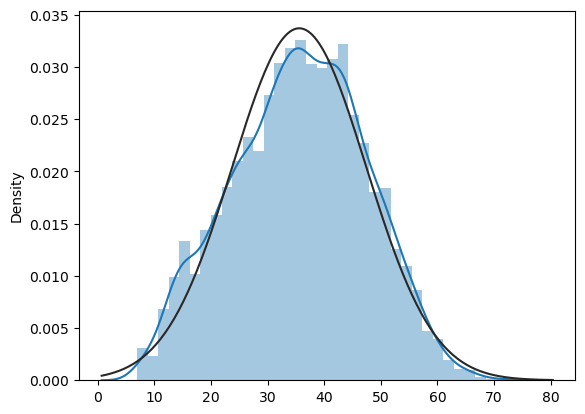

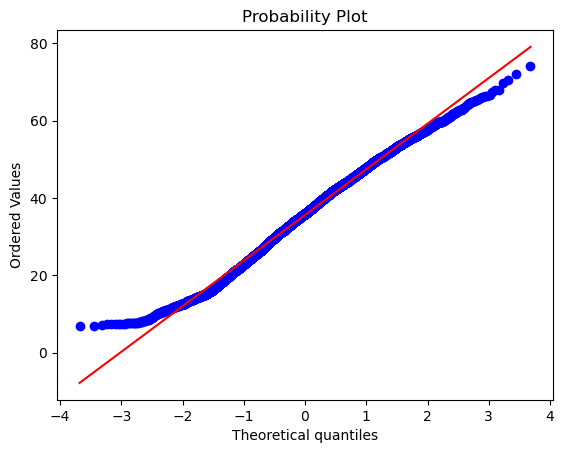

In [19]:
sns.distplot(y_train,fit = stats.norm)
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

In [20]:
Scalar = StandardScaler()
X_train = Scalar.fit_transform(X_train)
X_test = Scalar.transform(X_test)

In [21]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42,max_depth=4)),
    ('XGBRegressor',XGB.XGBRegressor(random_state=42,max_depth=3))
]

In [22]:
for clf_name, clf in regressors:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{clf_name}:')
    print('R2 Score: ', r2_score(y_test, y_pred))
    print("MSE: ", mean_squared_error(y_test, y_pred))
    print("MAE: ", mean_absolute_error(y_test, y_pred))
    print('------------------------------------')

Linear Regression:
R2 Score:  -6.180061352097674e+22
MSE:  8.38817206061235e+24
MAE:  154344261693.4186
------------------------------------
Random Forest Regressor:
R2 Score:  0.6912213671785624
MSE:  41.91039786146652
MAE:  5.011977217933317
------------------------------------
XGBRegressor:
R2 Score:  0.6950134708453484
MSE:  41.39569717782552
MAE:  4.95799610583634
------------------------------------


In [25]:
reg_xg = XGB.XGBRegressor(random_state=42,max_depth=3)
reg_xg.fit(X_train, y_train)

y_test_preds = reg_xg.predict(X_test)
print("MAE: ", mean_absolute_error(y_test, y_test_preds))

MAE:  4.95799610583634


In [26]:
import joblib

In [28]:
joblib.dump(reg_xg,'model_xg.pkl')

['model_xg.pkl']